In [2]:
from datasets import load_dataset
emotions = load_dataset('emotion')

/Users/radhika/Desktop/Personal/Interview related content/NLP/NLP_with_Transformers/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [8]:
len(train_ds)

16000

In [9]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [10]:
train_ds.column_names

['text', 'label']

In [11]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [12]:
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

Way to load different formats:
- CSV: load_dataset('csv', data_files='data.csv')

In [14]:
# From datasets to dataframes
import pandas as pd
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [15]:
# Int2str method to convert labels ids to label names
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head() 

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


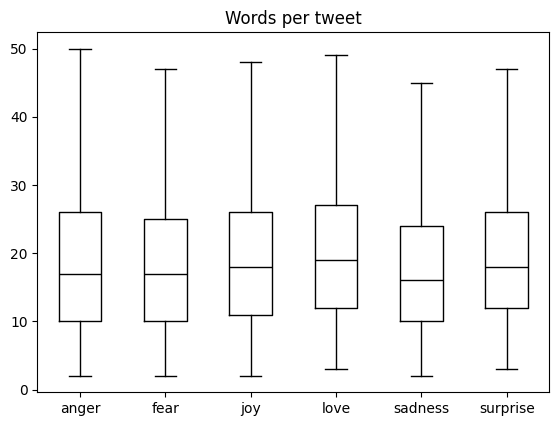

In [19]:
# How long are out tweets?
import matplotlib.pyplot as plt
df['Words per tweet'] = df['text'].str.split().apply(len)
df.boxplot("Words per tweet", by='label_name', grid=False,
           showfliers=False, color='black')
plt.suptitle('')
plt.xlabel('')
plt.show()

### From text to tokens

Models take input as tokens and not the strings. So tokenisation becomes very important.
1. Convert input string to tokens.
2. Convert tokens to numeric values : Numericalisation

In [3]:
emotions.set_format()

In [7]:
# Character Tokenisation
text = "Tokenizing text is a core task of NLP."
tokenised_text = list(text)
tokenised_text[:5]

['T', 'o', 'k', 'e', 'n']

In [8]:
# token 2 id
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenised_text)))}
token2idx

{' ': 0,
 '.': 1,
 'L': 2,
 'N': 3,
 'P': 4,
 'T': 5,
 'a': 6,
 'c': 7,
 'e': 8,
 'f': 9,
 'g': 10,
 'i': 11,
 'k': 12,
 'n': 13,
 'o': 14,
 'r': 15,
 's': 16,
 't': 17,
 'x': 18,
 'z': 19}

In [16]:
input_ids = [token2idx[token] for token in tokenised_text] # So whole string -> list(characters) -> list(ids)
print(input_ids)
print("Length of input ids: ", len(input_ids))
print("Number of unique ids: ", max(input_ids)+1)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]
Length of input ids:  38
Number of unique ids:  20


In [ ]:
# Ids -> One Hot Vector Technique | For represenation of each review/ input string.
import torch
import torch.nn.functional as F
input_ids = torch.tensor(input_ids)

#Important to have num_classes, otherwise vector may end up being shorter than length of vocabulary! -> might need padding manually
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape 

# for each of the character, vector with 20 dimensions is used!

torch.Size([38, 20])

In [17]:
print(f"Token: {tokenised_text[0]}")
print(f"Token index: {input_ids[0]}")
print(f"One-Hot: {one_hot_encodings[0]}")


Token: T
Token index: 5
One-Hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


#### Word Tokenisation

Input str -> Words -> Ids

+ Positive: Using words from the outset enables the model to skip the step of learning words from characters, and thereby reduces the complexity of the training process.
- Negative: Including punctuations, conjugations, misspellings can lead to emplotion of vocabulary length unlike in character modelling which is just 26 letters + special characters!

Workdaround: Applying stemming/ lemmatization can reduce the vocab length at the expense of losing some information in the text

Why huge vocab is problem:
Case: 1 million vocab lenght. First step to convert this into 1000 dimnesional input to a NN. Now the first layer weight matrix is of dimension: 10^6 x 10^3 = 10^9 = 1 billion paramters!

Solution: Consider 1 lac(10% of 1 million) most common words and then keep other words as UNK(Unknown token) at expense of losing info on those

Final Solution : Sub word tokenisation -> Combination of  Characters and Words!

In [ ]:
# Subword Tokenisation